In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [7]:
def generate_data(seq_length=1000):
    x = np.linspace(0, 100, seq_length)
    y = np.sin(x) + 0.1 * np.random.randn(seq_length)
    return y.reshape(-1, 1)

In [9]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:i+seq_length])
        ys.append(data[i+seq_length])
    return np.array(xs), np.array(ys)

In [11]:
if __name__ == "__main__":
    raw_data = generate_data(1100)
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(raw_data)
    seq_len = 50
    X, y = create_sequences(data_scaled, seq_len)
    X_train = torch.tensor(X[:-100], dtype=torch.float32)
    y_train = torch.tensor(y[:-100], dtype=torch.float32)
    X_test = torch.tensor(X[-100:], dtype=torch.float32)
    y_test = torch.tensor(y[-100:], dtype=torch.float32)

In [13]:
    input_dim = 1
    d_model = 64
    nhead = 4
    num_layers = 1
    embedding = nn.Linear(input_dim, d_model)

In [15]:
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)

In [17]:
    encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
    transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
    fc_out = nn.Linear(d_model, 1)

/opt/anaconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [19]:
    epochs = 50
    lr = 0.001
    criterion = nn.MSELoss()
    params = list(embedding.parameters()) + list(transformer.parameters()) + list(fc_out.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)

In [21]:
    for epoch in range(epochs):
        embedding.train()
        transformer.train()
        fc_out.train()
        optimizer.zero_grad()
        x_embed = embedding(X_train)
        x_pos = x_embed + pe[:, :X_train.size(1)].to(X_train.device)
        x_trans = transformer(x_pos)
        output = fc_out(x_trans[:, -1, :])
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 5, Loss: 0.1941
Epoch 10, Loss: 0.0693
Epoch 15, Loss: 0.1364
Epoch 20, Loss: 0.0304
Epoch 25, Loss: 0.0543
Epoch 30, Loss: 0.0166
Epoch 35, Loss: 0.0220
Epoch 40, Loss: 0.0085
Epoch 45, Loss: 0.0117
Epoch 50, Loss: 0.0093


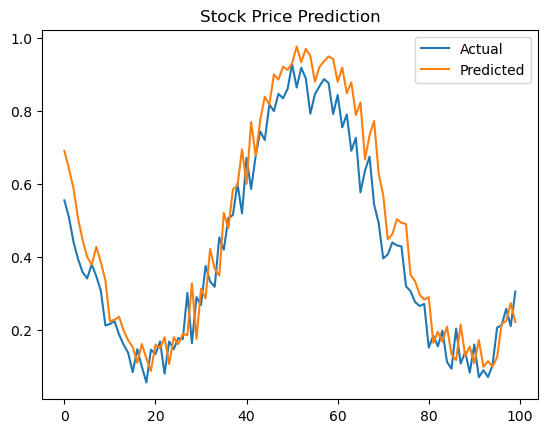

In [23]:
    embedding.eval()
    transformer.eval()
    fc_out.eval()
    with torch.no_grad():
        x_embed = embedding(X_test)
        x_pos = x_embed + pe[:, :X_test.size(1)].to(X_test.device)
        x_trans = transformer(x_pos)
        preds = fc_out(x_trans[:, -1, :]).squeeze().numpy()
        actual = y_test.numpy().squeeze()
        plt.plot(actual, label='Actual')
        plt.plot(preds, label='Predicted')
        plt.legend()
        plt.title("Stock Price Prediction")
        plt.show()